Naive Mean Model Score: 0.5
Baseline Logistic Regression Score: 0.7356105810651266


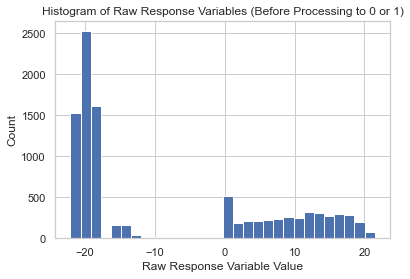

In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

np.random.seed(109)

X_data = pd.read_csv('NHANESI_X.csv')
y_data = pd.read_csv('NHANESI_y.csv')

X_data = X_data.drop('Unnamed: 0', axis = 1)
y_data = y_data.drop('Unnamed: 0', axis = 1)

plt.hist(x=y_data.values, bins=30)
plt.xlabel("Raw Response Variable Value")
plt.ylabel("Count")
plt.title("Histogram of Raw Response Variables (Before Processing to 0 or 1)")

y_data['y'] = (abs(y_data['y'])>=18)*1

# Splitting data first
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,
                                                    random_state = 109, shuffle=True, 
                                                    stratify=y_data['y'])

# Standardizing data to aid in model convergence and performance
scaler = StandardScaler()
X_train_imputed = scaler.fit_transform(X_train)
X_test_imputed = scaler.fit_transform(X_test)

# Imputing X_data with KNN imputer, n_neighbors = 1 to handle NaN values
imputer = KNNImputer(n_neighbors=1)
X_train_impute = imputer.fit_transform(X_train_imputed)
X_test_impute = imputer.fit_transform(X_test_imputed)

# Turning ndarray into DF; resetting column names
X_train_impute = pd.DataFrame(X_train_impute, columns = X_data.columns)
X_test_impute = pd.DataFrame(X_test_impute, columns = X_data.columns)

y_train = pd.DataFrame(y_train.values, columns = y_data.columns)
y_test = pd.DataFrame(y_test.values, columns = y_data.columns)

# Resetting variable values to aid in interpretabiltiy 
X_train_impute['Sex'] = X_train_impute['Sex'].subtract(1)
X_test_impute['Sex'] = X_test_impute['Sex'].subtract(1)
X_train_impute['Race'] = X_train_impute['Race'].subtract(1)
X_test_impute['Race'] = X_test_impute['Race'].subtract(1)

# Baseline KNN model (n = DF size, so essentially mean) on imputed data
baseline_kNN_model = KNeighborsClassifier(n_neighbors=len(X_train_impute)).fit(X_train_impute,y_train.values.ravel())
y_pred = baseline_kNN_model.predict(X_test_impute)

baseline_kNN_model_accuracy = roc_auc_score(y_test, y_pred)
print("Naive Mean Model Score:", baseline_kNN_model_accuracy)

# Logistic regression model on dropped data
logit_base = LogisticRegression(max_iter=5000).fit(X_train_impute,y_train.values.ravel())
y_pred = logit_base.predict(X_test_impute)

logit_base_test_accuracy = roc_auc_score(y_test, y_pred)
print("Baseline Logistic Regression Score:", logit_base_test_accuracy)

## Single Decision Tree (CV) Performance

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

depths = list(range(1, 51))

def calc_meanstd(X_train, y_train, depths):
    train_scores = []
    cvmeans = []
    cvstds = []
    cv_score_tracker = {}
    
    for depth in depths:
        dtree = DecisionTreeClassifier(max_depth=depth)
        dtree.fit(X_train, y_train)
        train_score = dtree.score(X_train, y_train)
        scores = cross_val_score(dtree, X_train, y_train, cv=5, scoring="roc_auc")
        train_scores.append(train_score)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
        cv_score_tracker[depth] = scores.mean()
        
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    
    return cvmeans, cvstds, train_scores, cv_score_tracker

cvmeans, cvstds, train_scores, scores_dict = calc_meanstd(X_train_impute, y_train.values.ravel(), depths)


In [ ]:
plt.figure(figsize=(15,10))
plt.plot(depths, train_scores, label="Non-CV Training Scores")
plt.plot(depths, cvmeans, label="CV Estimated Mean Score +/- 2 SD")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, color="C1", alpha=0.5)
plt.legend()
plt.title("Non-CV Training and CV Accuracy vs. Max Depth")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths);

In [ ]:
best_depth = max(scores_dict, key=scores_dict.get)
dtree = DecisionTreeClassifier(max_depth=best_depth).fit(X_train_impute, y_train.values.ravel())
best_cv_tree_train_score = dtree.score(X_train_impute, y_train.values.ravel())
best_cv_tree_test_score = dtree.score(X_test_impute, y_test)
print(f"Best CV Tree Train Score: {best_cv_tree_train_score}")
print(f"Best CV Tree Test Score: {best_cv_tree_test_score}")
print(f"Best Depth: {best_depth}")
                                        

### Single Decision Tree Interpretation

In [ ]:
shap_values = shap.TreeExplainer(dtree).shap_values(X_train_impute)
shap.summary_plot(shap_values, X_train_impute, plot_type="bar", show=False)
plt.title("Single Tree SHAP Summary")
plt.savefig(f"Single_Tree_Plots/Single_Tree_SHAP_Summary");

for i in range(18):
    shap.dependence_plot(X_train.columns[i], shap_values[1], X_train_impute, show=False);
    plt.title(f"Single Tree SHAP Dependence: {X_train.columns[i]}")
    plt.savefig(f"Single_Tree_Plots/Single_Tree_SHAP_Dependence_{X_train.columns[i]}");
    

## Decision Trees with Bagging: 

In [ ]:
tree_depth = 5
model_counts = [1,2,3,4,5,10,20,50,100,200]
train_scores = {}
test_scores = {}

for model_count in model_counts:
    bagging_model = BaggingClassifier(DecisionTreeClassifier(max_depth=tree_depth, random_state=69), 
                                      n_estimators=model_count)

    bagging_model.fit(X_train_impute, y_train.values.ravel())

    y_pred_train = bagging_model.predict(X_train_impute)
    y_pred_test = bagging_model.predict(X_test_impute)

    bagging_model_train_accuracy = roc_auc_score(y_train, y_pred_train)
    bagging_model_test_accuracy = roc_auc_score(y_test, y_pred_test)
    
    train_scores[model_count] = bagging_model_train_accuracy
    test_scores[model_count] = bagging_model_test_accuracy

    
best_count = max(test_scores, key=test_scores.get)
bagging_model = BaggingClassifier(DecisionTreeClassifier(max_depth=tree_depth, random_state=69), 
                                      n_estimators=best_count)

bagging_model.fit(X_train_impute, y_train.values.ravel())

y_pred_train = bagging_model.predict(X_train_impute)
y_pred_test = bagging_model.predict(X_test_impute)

bagging_model_train_accuracy = roc_auc_score(y_train, y_pred_train)
bagging_model_test_accuracy = roc_auc_score(y_test, y_pred_test)

print("Best Bagging Model Accuracy on Train: ")
print(bagging_model_train_accuracy)
print("\n Best Bagging Model Accuracy on Test: ")
print(bagging_model_test_accuracy)

num_trees = list(model_counts)

fig = plt.figure(1)
plt.plot(num_trees, list(train_scores.values()), label = "Train Accuracy")
plt.plot(num_trees, list(test_scores.values()), label = "Test Accuracy")
plt.legend()
plt.title("Model Accuracy vs. Number of Bootstrapped Trees")
plt.ylabel("ROC AUC")
plt.xlabel("Number of Trees")
plt.show()


In [ ]:
param_grid = {'base_estimator__max_depth' : range(1,11), 
              'n_estimators' : [1,2,3,4,5,10,20,50,100]}

bagging_grid = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()),
                                              param_grid, scoring = "roc_auc",verbose=1)

bagging_grid.fit(X_train_impute, y_train.values.ravel())
bagging_grid_best = bagging_grid.best_estimator_

y_pred_train = bagging_grid.predict(X_train_impute)
y_pred_test = bagging_grid.predict(X_test_impute)
bagging_model_train_accuracy = roc_auc_score(y_train, y_pred_train)
bagging_model_test_accuracy = roc_auc_score(y_test, y_pred_test)
print(f"Best Grid Search Bagging Model Score on Train: {bagging_model_train_accuracy}")
print(f"Best Grid Search Bagging Model Score on Test: {bagging_model_test_accuracy}")
                            

## Bagging Model Interpretation

In [ ]:
importances = np.mean([tree.feature_importances_ for tree in bagging_grid_best.estimators_], axis=0)
std = np.std([tree.feature_importances_ for tree in bagging_grid_best.estimators_], axis=0)
indices = np.argsort(importances)

features = X_train_impute.columns
plt.barh(range(len(indices)), importances[indices], color='b', 
         xerr=std[indices], align='center', ecolor='orange')
plt.title('Feature Importances')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.xlim(0, 0.7)
plt.show()

In [ ]:
r = permutation_importance(bagging_grid, X_test_impute, y_test.values.ravel(), n_repeats=15)                           

In [ ]:
indices = np.argsort(r.importances_mean)
std = r.importances_std

fig = plt.figure()
plt.barh(range(len(indices)), r.importances_mean[indices], color='b', 
         align='center', xerr=std[indices], ecolor="orange")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Permutation Feature Importances')
plt.xlabel('Permutation Feature Importance')
plt.xlim(0, 0.25)
fig.tight_layout()
plt.show()
